<a href="https://colab.research.google.com/github/afiliot/DLiP-TP3/blob/master/FILIOT_ALEXANDRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


> **Set your path: it should end by /FILIOT_ALEXANDRE/**. The folder is the zip file which contains the folders simulations and weights.

In [0]:
path = input()

> In the wording, we assume that we "have a limited computational budget (e.g., no GPUs)". On collab, one can have access to GPUs, which make the trainings much faster and convenient for doing cross-validations, gridsearch/finetuning, avering the network performance on several runs, etc... For more convenience, I set ``device = 'cuda' if torch.cuda.is_available() else 'cpu'``which will be equal to `'cuda'` on Collab. The code is totally adaptable when `device='cpu', i.e. nothing has to be changed.

In [6]:
# Basic packages
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from copy import deepcopy
from tqdm import tqdm

# Packages for DL
from torchvision.datasets.cifar import CIFAR10 as _CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

# Data Augmentation
#!pip install Augmentor
import Augmentor

# Wavelet transform
#!pip install kymatio
import kymatio

# Skorch
#!pip install skorch
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, ProgressBar, LRScheduler, WarmRestartLR


# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Remove warnings introduced by the small number of members per class in Kfold
import warnings
warnings.filterwarnings('ignore')

# Set device (on collab, device='cuda', on personal laptop, device='cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Working with 1 GPU: '+torch.cuda.get_device_name(0))

Working with 1 GPU: Tesla K80


Data loader inspired from  https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py. 

In [0]:
class CIFAR10(_CIFAR10):
    def __init__(self, root, start=None, end=None, is_labeled=True, train=True, transform=None, target_transform=None, download=False):
        """
        Args:
            start: first index of the set
            end: last index of the set
            is_labeled: for the X set, which is unlabeled
        """
        super(CIFAR10, self).__init__(root, train, transform, target_transform, download)                           
        self.is_labeled = is_labeled
        self.data = self.data[start:end]
        self.targets = self.targets[start:end]
        
    def __getitem__(self, index):
        img, target = super(CIFAR10, self).__getitem__(index)

        if self.is_labeled:
            return img, target
        return img

> Data vizualization of first 100 samples.

In [0]:
def plot_cifar(X, size):
    """
    Plot the whole training data set on a grid.
    """
    fig, axes1 = plt.subplots(size, size, figsize=(size-3, size-3))
    for j in range(size):
        for k in range(size):
            i = size * j + k
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(X[i])

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

> Many issues arise from small data.
- First,  over-fitting becomes much harder to avoid. Worse, over-fit is more likely to occur not only on the training data, but also on the validation set as well. Indeed, the number of observations in training and validation is too few to give meaningful performance estimate. That's why finetuning parameters should be done carefully. In fact, one should not over-use cross-validation data for hyper-parameter optimization, or not at all. Here, 100 training samples of observations results in about 25 samples for validation, which is way too few to guide parameter search optimally. 
- Then, models are more sensitive to outliers. Here, even few outliers (1 to 10) can significantly alter the model and dramatically impact the performance. Moreover, noise in general becomes a real issue, be it in the target variable or in some images.
- At last, one can speak about all form of uncertainty that, in presence of small data, are more significant: measurement errors, missing values, sampling bias). 
>
>
> Now, how to tackle those issues (generally speaking).
>
>- First, use simpler models with lesser degrees of freedom, which contribute to more robust estimates. 
- Control the data in terms of pre-processing (outliers, missing values, etc...).
- Reduce overfitting by ensemble learning (stacking, combining classifiers), regularizing, and augmenting the data set. 
- Always report marging of error as models on small data have larger confidence intervals in terms of predictions. 
- Use domain expertise as in weak-supervised learning. 
>
>In the TP, one will take a look at several techniques to tackle the issues of small data. Let's specialize to our data, CIFAR-10. 
>- *What I do [1/2]*: one may effectively look for using simple deep learning models, i.e. "simple" neural network. In fact, VGG or ResNet architecture are not quite simple in terms of numbers of parameters... But we will be very careful on regularization through, for instance, learning rate schedule, dropout or weight decay. To anticipate the next parts,  what will be the systematic approach to best predict the classes is the following:
  - Stick to the original architectures. Namely, don't use dropout neither in ResNet nor in VGG. 
  - Apply 2-fold cross-validation to determine the optimal learning rate, maximal number of epochs and batch size (hoping that the model won't overfit on the validation set). Weight decay is fixed set to $10^{-4}$ or $5\cdot 10^{-4}$.
  - Set the following Learning Rate Schedule: divise the learning rate by $10$ each $10$ epochs (I do this for simplicity as I struggled to use build-in function on Pytorch). 
  - Use the fine tuned hyperparameters and train the network with it multiple times in order to build confidence intervals. **Sometimes I will choose different parameters from the optimized ones, in particular for ResNet18**
  - **The accuracies of reference on the full data set are available in the conclusion.**
- *What I do [2/2]*: a bit of data augmentation is done as a basis for training. Namely, `randomCrop(32, padding=4)` and `RandomHorizontalFlip()`. ** Question 8, I compare more complex data augmentation strategies and no data augmentation at all, the latter case is thus not done for question 3 and 4 (misunderstanding of the wording)**.
- *What I don't do*: I won't proceed in data pre-processing as CIFAR-10 data set is pretty clean already. I won't proceed neither in stacking models (for simplicity) and in order to stick to the assumption of a limited computational budget.
>
> Finally, one may talk about transfer, semi-supervised and weakly-supervised learning that are very useful to handle small data. All techniques seen in the lecture will be applied in the next sections and are considered as bringing state-of-the-art performance on CIFAR-10 for very few training samples. 






# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

> Here, one stick to the ResNet18 classical architecture from He et al. "Deep Residual Learning for Image Recognition" (2015). I re-used the suggested piece of code available on GitHub. In order to apply hyperparameters tuning, I use ``skorch`` package, which needs to be installed beforehand. It is really helpful for doing gridsearching in a compact way. 
>
> Kuang Liu proposes a bunch of models applied to CIFAR-10 data set. 

In [0]:
class BasicBlock(nn.Module):
    """
    Define a block from ResNet architecture.
    Source: https://github.com/kuangliu/pytorch-cifar
    """
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
      
class ResNet(nn.Module):
    """
    ResNet network from  He et al. "Deep Residual Learning for Image Recognition" (2015).
    Source: https://github.com/kuangliu/pytorch-cifar
    """
    def __init__(self, block=BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

> Now I apply transformation on the CIFAR-10 data set. Those transformations are directly inspired from Kuang Liu. **In fact, I struggled pretty hard to retrieve the 20% accuracy from the wording.** This is due to the fact that I didn't apply those transformations (except normalization). My cross-validations and training were giving at most 18% accuracy on test set, which was not expected. I don't know if those transformations should have been applied. That's why I choose to test the models with no data augmentation at all in question 8.

In [25]:
# Transform on train
transform_train =  transforms.Compose([transforms.RandomCrop(32, padding=4), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# Transform on test
transform_test =  transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Load data set 
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)

# Extract X, y
X_train, y_train, X_test, y_test = dataset_train.data, dataset_train.targets, dataset_test.data, dataset_test.targets

0it [00:00, ?it/s]

100%|█████████▉| 170418176/170498071 [00:43<00:00, 1864659.91it/s]

Files already downloaded and verified


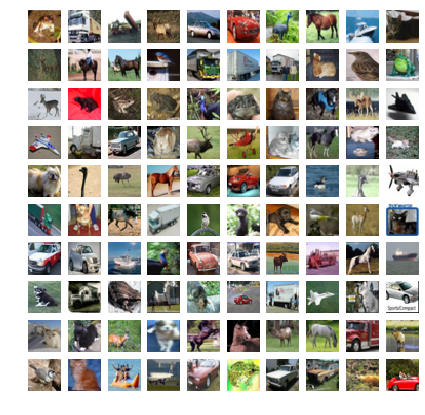

In [26]:
# Plot training samples
plot_cifar(X_train, 10)

> Let's try cross-validation on some parameters. One may only look at the maximal number of epochs, learning rate and batch-size. Indeed, He et al. (2015) do not use any dropout. They use SGD solver. 

In [0]:
# Define the network. Verbose=0 in order to avoid too many callbacks.
# Learning rate are automatically scheduled thanks to LRScheduler.
ResNet18 = NeuralNetClassifier(
    ResNet().double(),
    iterator_train__shuffle=True,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5, threshold=1e-4)],
    device=device,
    verbose=0)

# Allowing many combinations is doable as, in Collab, GPU is available.
params = {'lr': [0.005, 0.01, 0.02, 0.05],
          'batch_size': [5, 10, 15, 20],
          'max_epochs': [5, 10, 20, 30]}

# I do not use X_train and y_train here in order to avoid errors. 
### First with the Basic Block
# CV is done over 2 stratified folds.
gs_bb = GridSearchCV(ResNet18, params, refit=True, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=0)
print('...Gridsearch with ResNet18...')
t = time.time()
gs_bb.fit(np.array([X.reshape(3, 32, 32).astype('double') for X in X_train]), np.array(y_train).astype('int64'))
print('Cross-validation finished. Time elapsed: {:5.2f} sec.'.format(time.time()-t))
print('Best accuracy on val set: {:0.4f}, best parameters: '.format(gs_bb.best_score_), gs_bb.best_params_)
pickle.dump(gs_bb, open(path+'cv_resnet18.pk', 'wb'))

...Gridsearch with ResNet18...
Cross-validation finished. Time elapsed: 783.64 sec.
Best accuracy on val set: 0.2200, best parameters:  {'batch_size': 5, 'lr': 0.005, 'max_epochs': 10}


> Now that hyperparameters has been tuned, let's see how our network behaves on the test set.

In [0]:
lr, momentum, weight_decay = 0.005, 0.9, 5e-4
max_epochs = 20 # twice the optimal one /!\
batch_size = 5

In [0]:
def init_resnet():
  ResNet18 = ResNet().to(device)
  ResNet18 = ResNet18.to(device)
  if device == 'cuda':
      ResNet18 = torch.nn.DataParallel(ResNet18)
      cudnn.benchmark = True
  return ResNet18

ResNet18 = init_resnet()

In [0]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

> Here I code a function to train and/or test several times a given network. Those functions are very useful for the whole homework.

In [0]:
# Training
def train(net, epoch, optimizer, criterion, train_loader, verbose, scattering):
    net.train()
    train_loss = 0; correct = 0; total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if scattering is None:
          outputs = net(inputs)
        else:
          outputs = net(scattering(inputs))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    loss, acc =  train_loss / (batch_idx+1), 100 * correct / total
    if verbose==1:
      print('\n...Epoch %d...\n...Train_loss: %.3f | Train_acc: %.3f%% |... ' % (epoch, loss, acc))  
    return loss, acc

# Testing
def test(net, epoch, criterion, test_loader, verbose, scattering):
    net.eval()
    test_loss = 0; correct = 0; total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            if scattering is None:
              outputs = net(inputs)
            else:
              outputs = net(scattering(inputs))
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    loss, acc =  test_loss / (batch_idx+1), 100 * correct / total
    if verbose==1:
      print('...Test_loss: %.3f | Test_acc: %.3f%% |... ' % (loss, acc))  
    return loss, acc

# Both
def train_test(init, name, max_epochs, criterion, train_loader, test_loader, N=1, verbose=0, LRreduce=0, scattering=None):
    train_loss, test_loss, train_acc, test_acc = np.zeros((N, max_epochs)), np.zeros((N, max_epochs)), np.zeros((N, max_epochs)), np.zeros((N, max_epochs))
    for n in range(N):
      t = time.time()
      print('...Training n°%d...'% (n+1))
      lr_ = deepcopy(lr)
      net = init()
      optimizer = optim.SGD(net.parameters(), lr=lr_, momentum=0.9, weight_decay=5e-4)
      for epoch in range(1, max_epochs+1):
          if epoch%10==0 and LRreduce == 1:
              lr_*=0.1
              optimizer = torch.optim.SGD(net.parameters(), lr=lr_, momentum=0.9,
                                          weight_decay=5e-4)
          l_tr, a_tr = train(net, epoch, optimizer, criterion, train_loader, verbose, scattering)
          l_te, a_te = test(net, epoch, criterion, test_loader, verbose, scattering)
          train_loss[n, epoch-1]=l_tr
          test_loss[n, epoch-1]=l_te
          train_acc[n, epoch-1]=a_tr
          test_acc[n, epoch-1]=a_te
          pickle.dump([train_loss, test_loss, train_acc, test_acc], open(path+'/Simulations/N'+str(N)+'LRr'+str(LRreduce)+'_train_test_'+name+'.pk', 'wb')) 
      i0 = np.argmax(test_acc[n])
      print('Time elapsed: %4.2f sec. | Best test_acc: %.3f%% | Best train_acc: %.3f%%' % (time.time()-t, test_acc[n, i0], train_acc[n, i0]))
    return train_loss, test_loss, train_acc, test_acc

In [67]:
# Let's see what it has
train_loss_r18, test_loss_r18, train_acc_r18, test_acc_r18 = train_test(init_resnet, name='resnet18', max_epochs=max_epochs,
                                                                        criterion=criterion,
                                                                        train_loader=train_loader, test_loader=test_loader,
                                                                        N=10, verbose=0)

...Training n°1...
Time elapsed: 403.30 sec. | Best test_acc: 24.490% | Best train_acc: 40.000%
...Training n°2...
Time elapsed: 403.00 sec. | Best test_acc: 23.950% | Best train_acc: 37.000%
...Training n°3...
Time elapsed: 402.90 sec. | Best test_acc: 23.440% | Best train_acc: 30.000%
...Training n°4...
Time elapsed: 402.29 sec. | Best test_acc: 23.830% | Best train_acc: 30.000%
...Training n°5...
Time elapsed: 403.46 sec. | Best test_acc: 25.370% | Best train_acc: 31.000%
...Training n°6...
Time elapsed: 400.96 sec. | Best test_acc: 24.120% | Best train_acc: 37.000%
...Training n°7...
Time elapsed: 403.07 sec. | Best test_acc: 23.350% | Best train_acc: 44.000%
...Training n°8...
Time elapsed: 402.29 sec. | Best test_acc: 23.520% | Best train_acc: 32.000%
...Training n°9...
Time elapsed: 402.36 sec. | Best test_acc: 23.310% | Best train_acc: 31.000%
...Training n°10...
Time elapsed: 404.01 sec. | Best test_acc: 25.300% | Best train_acc: 35.000%


## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

In [0]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    """
    VGG architecture.
    Source: https://github.com/kuangliu/pytorch-cifar
    """
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [0]:
VGG16 = NeuralNetClassifier(
    VGG('VGG16').double(),
    iterator_train__shuffle=True,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.95,
    optimizer__weight_decay=1e-4,
    device=device,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5, threshold=1e-4)],
    verbose=0)

In [0]:
params = {'lr': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
          'batch_size': [5, 10, 15, 20, 25, 30],
          'max_epochs': [10, 20, 30, 50, 80, 100]}

# I do not use X_train and y_train here in order to avoid errors. 
### First with the Basic Block
# CV is done over 2 stratified folds.
gs_vgg16 = GridSearchCV(VGG16, params, refit=False, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=0)
print('...Gridsearch for VGG16...')
t = time.time()
gs_vgg16.fit(np.array([X.reshape(3, 32, 32).astype('double') for X in X_train]), np.array(y_train).astype('int64'))
print('Cross-validation finished. Time elapsed: {:5.2f} sec.'.format(time.time()-t))
print('Best accuracy on val set: {:0.4f}, best parameters: '.format(gs_vgg16.best_score_), gs_vgg16.best_params_)
pickle.dump(gs_vgg16, open(path+'cv_vgg16.pk', 'wb'))

...Gridsearch for VGG16...
Cross-validation finished. Time elapsed: 1899.75 sec.
Best accuracy on val set: 0.2000, best parameters:  {'batch_size': 5, 'lr': 0.05, 'max_epochs': 20}


In [0]:
lr, momentum, weight_decay = 0.05, 0.9, 1e-4
max_epochs = 20
batch_size = 5

In [0]:
def init_vgg():
  VGG16 = VGG('VGG16').to(device)
  if device == 'cuda':
      net = torch.nn.DataParallel(VGG16)
      cudnn.benchmark = True
  return VGG16

VGG16 = init_vgg()

In [0]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# And the optimizer
optimizer = optim.SGD(VGG16.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has
train_loss_vgg16, test_loss_vgg16, train_acc_vgg16, test_acc_vgg16 = train_test(init_resnet, name='vgg16', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)

...Training n°1...
Time elapsed: 433.49 sec. | Best test_acc: 19.450% | Best train_acc: 24.000%
...Training n°2...
Time elapsed: 432.06 sec. | Best test_acc: 18.790% | Best train_acc: 21.000%
...Training n°3...
Time elapsed: 439.13 sec. | Best test_acc: 18.990% | Best train_acc: 23.000%
...Training n°4...
Time elapsed: 439.03 sec. | Best test_acc: 14.260% | Best train_acc: 16.000%
...Training n°5...
Time elapsed: 438.80 sec. | Best test_acc: 20.980% | Best train_acc: 25.000%
...Training n°6...
Time elapsed: 437.91 sec. | Best test_acc: 17.120% | Best train_acc: 20.000%
...Training n°7...
Time elapsed: 439.30 sec. | Best test_acc: 17.300% | Best train_acc: 22.000%
...Training n°8...
Time elapsed: 447.42 sec. | Best test_acc: 20.120% | Best train_acc: 19.000%
...Training n°9...
Time elapsed: 443.33 sec. | Best test_acc: 20.570% | Best train_acc: 27.000%
...Training n°10...
Time elapsed: 432.79 sec. | Best test_acc: 17.070% | Best train_acc: 16.000%


> Comparison : the cell below compare the accuracies on train and test set averaged on 10 independent simulations with same hyperparameters. From those numbers, one can strongly recommand using ResNet18. It has 25% less trainable parameters, is faster to train and produces higher train and test accuracies with comparable or better standard deviations. 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |
|   VGG16  | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |


> To run the following cell, you should set a path that like `./simulations/` as all files of type "train_test" are available in this folder.

In [35]:
# Load results from multiple trainings 
train_loss_r18, test_loss_r18, train_acc_r18, test_acc_r18 = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18.pk', 'rb'))
train_loss_vgg16, test_loss_vgg16, train_acc_vgg16, test_acc_vgg16 = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16.pk', 'rb'))

# Define a small function to return mean and std
def stat(train_acc, test_acc):
  imax = np.argmax(test_acc, axis=1)
  train_acc_, test_acc_ = train_acc[np.arange(10), imax], test_acc[np.arange(10), imax]
  return np.mean(train_acc_), np.std(train_acc_), np.mean(test_acc_), np.std(test_acc_)

# Compute corresponding stats for ResNet18 and VGG16
m_tr_r18, std_tr_r18, m_te_r18, std_te_r18 = stat(train_acc_r18, test_acc_r18)
m_tr_v16, std_tr_v16, m_te_v16, std_te_v16 = stat(train_acc_vgg16, test_acc_vgg16)

# Print comparison
tpvgg16 = sum(p.numel() for p in VGG16.parameters() if p.requires_grad)
tpresnet18 = sum(p.numel() for p in ResNet18.parameters() if p.requires_grad)
print('ResNet18: %d training parameters | Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (tpresnet18, m_tr_r18, std_tr_r18, m_te_r18, std_te_r18))
print('VGG16:    %d training parameters | Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (tpvgg16, m_tr_v16, std_tr_v16, m_te_v16, std_te_v16))

ResNet18: 11173962 training parameters | Train accuracy: 34.700 ± 4.518% | Test accuracy: 24.068 ± 0.725%
VGG16:    14728266 training parameters | Train accuracy: 21.300 ± 3.466% | Test accuracy: 18.465 ± 1.940%


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

> I choose VGG16.

In [0]:
def init_vgg_pretrained():
  VGG16_pretrained = models.vgg16(pretrained=True)

  # Freeze model weights
  for param in VGG16_pretrained.parameters():
      param.requires_grad = False

  # Retrain last layer only
  VGG16_pretrained.classifier[6] = nn.Sequential(
                        nn.Linear(4096, 256), 
                        nn.ReLU(), 
                        nn.Dropout(0.4),
                        nn.Linear(256, 10),                   
                        nn.LogSoftmax(dim=1))
  # Move to gpu
  VGG16_pretrained = VGG16_pretrained.to('cuda')
  # Distribute across 2 gpus
  VGG16_pretrained = nn.DataParallel(VGG16_pretrained)
  return VGG16_pretrained

VGG16_pretrained = init_vgg_pretrained()

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in VGG16_pretrained.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in VGG16_pretrained.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


# Use skorch

VGG16_pretrained_ = NeuralNetClassifier(
    VGG16_pretrained.double(),
    iterator_train__shuffle=True,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.95,
    optimizer__weight_decay=1e-4,
    device=device,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5, threshold=1e-4)],
    verbose=0)

In [0]:
# Allowing many combinations is doable as, in Collab, GPU is available.
params = {'lr': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05],
          'batch_size': [15, 20, 25, 30, 35, 40, 50],
          'max_epochs': [10, 20, 30, 40, 50, 70, 80, 100]}


# I do not use X_train and y_train here in order to avoid errors. 
### First with the Basic Block
# CV is done over 2 stratified folds.
gs_vgg16_ptrained = GridSearchCV(VGG16_pretrained_, params, refit=False, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=0)
print('...Gridsearch for pretrained VGG16 (only last layer learned)...')
t = time.time()
gs_vgg16_ptrained.fit(np.array([X.reshape(3, 32, 32).astype('double') for X in X_train]), np.array(y_train).astype('int64'))
print('Cross-validation finished. Time elapsed: {:5.2f} sec.'.format(time.time()-t))
print('Best accuracy on val set: {:0.4f}, best parameters: '.format(gs_vgg16_ptrained.best_score_), gs_vgg16_ptrained.best_params_)
pickle.dump(gs_vgg16_ptrained, open(path+'cv_vgg16_pretrained.pk', 'wb'))

...Gridsearch for pretrained VGG16 (only last layer learned)...
Cross-validation finished. Time elapsed: 2007.26 sec.
Best accuracy on val set: 0.2500, best parameters:  {'batch_size': 20, 'lr': 0.0001, 'max_epochs': 40}


In [0]:
lr, momentum, weight_decay = 1e-3, 0.9, 1e-4
max_epochs = 40
batch_size = 20

# Define the loss function
criterion = nn.CrossEntropyLoss()

# And the optimizer
optimizer = optim.SGD(VGG16_pretrained.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has
train_loss_vgg16p, test_loss_vgg16p, train_acc_vgg16p, test_acc_vgg16p = train_test(init_vgg_pretrained, name='vgg16pretrained', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)

...Training n°1...
Time elapsed: 437.82 sec. | Best test_acc: 37.960% | Best train_acc: 65.000%
...Training n°2...
Time elapsed: 433.83 sec. | Best test_acc: 37.560% | Best train_acc: 71.000%
...Training n°3...
Time elapsed: 435.52 sec. | Best test_acc: 37.790% | Best train_acc: 62.000%
...Training n°4...
Time elapsed: 435.49 sec. | Best test_acc: 38.830% | Best train_acc: 75.000%
...Training n°5...
Time elapsed: 434.41 sec. | Best test_acc: 36.780% | Best train_acc: 73.000%
...Training n°6...
Time elapsed: 433.69 sec. | Best test_acc: 37.780% | Best train_acc: 69.000%
...Training n°7...
Time elapsed: 433.63 sec. | Best test_acc: 39.030% | Best train_acc: 65.000%
...Training n°8...
Time elapsed: 433.92 sec. | Best test_acc: 37.950% | Best train_acc: 69.000%
...Training n°9...
Time elapsed: 432.96 sec. | Best test_acc: 37.780% | Best train_acc: 80.000%
...Training n°10...
Time elapsed: 433.08 sec. | Best test_acc: 37.630% | Best train_acc: 65.000%


In [37]:
# Load results from multiple trainings 
train_loss_vgg16p, test_loss_vgg16p, train_acc_vgg16p, test_acc_vgg16p = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16pretrained.pk', 'rb'))

# Compute corresponding stats for ResNet18 and VGG16
m_tr_v16p, std_tr_v16p, m_te_v16p, std_te_v16p = stat(train_acc_vgg16p, test_acc_vgg16p)

# Print comparison
tpvgg16p = sum(p.numel() for p in VGG16_pretrained.parameters() if p.requires_grad)
print('Pretrained VGG16: %d training parameters | Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (tpvgg16p, m_tr_v16p, std_tr_v16p, m_te_v16p, std_te_v16p))

Pretrained VGG16: 1051402 training parameters | Train accuracy: 69.400 ± 5.219% | Test accuracy: 37.909 ± 0.603%


Here are the accuracies: 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |
|   VGG16  | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |
|   Pretrained VGG16  | 40 | 69.400 ± 5.219% | 37.909 ± 0.603% |

Impressive !



## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

> For this part, I used the following weights: https://github.com/csinva/pytorch_gan_pretrained/tree/master/cifar10_dcgan/weights. There are obtained by training DCGAN on CIFAR-10 for 200 epochs. The architectures of the discriminator and generator are exactly the same as in https://github.com/pytorch/examples/tree/master/dcgan. I did that as I couldn't find a way to proper use the weights you suggested. 

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh())

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [132]:
# Transform on train
transform_train =  transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# Transform on test
transform_test =  transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Load data set 
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)

# Extract X, y
X_train, y_train, X_test, y_test = dataset_train.data, dataset_train.targets, dataset_test.data, dataset_test.targets

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
netD = Discriminator(ngpu=1).to(device)

# load weights
weights_D = torch.load(path+'/weights/netD_epoch_199.pth')
# weights_G = torch.load(path+'/weights/netG_epoch_199.pth')
netD.load_state_dict(weights_D)
# netG.load_state_dict(weights_G)

> I train a linear SVC on top of the discriminator.

In [136]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=1)

def get_features(dataloader):
  X, y = [], []
  model = nn.Sequential(*[netD.main[i].to(device) for i in range(11)])
  model.maxpool2 = nn.MaxPool2d(kernel_size=2)
  for _, (inputs, targets) in enumerate(dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    x = model(inputs)
    X.append(x.cpu().data.numpy().flatten())
    y.append(np.array(targets.cpu()))
  return X, y

X_train_, y_train_ = get_features(train_loader)
X_test_, y_test_ = get_features(test_loader)

from sklearn.model_selection import cross_validate as CV
from sklearn.svm import LinearSVC as SVC
for C in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50]:
  clf = SVC(C=C)
  print('C =',C,' | CV scores: ', CV(estimator=clf, X=X_train_, y=y_train_, cv=StratifiedKFold(n_splits=2), scoring='accuracy')['test_score'])

C = 0.0001  | CV scores:  [0.1509434  0.17021277]
C = 0.0005  | CV scores:  [0.1509434  0.17021277]
C = 0.001  | CV scores:  [0.1509434  0.17021277]
C = 0.005  | CV scores:  [0.18867925 0.21276596]
C = 0.01  | CV scores:  [0.18867925 0.23404255]
C = 0.05  | CV scores:  [0.20754717 0.21276596]
C = 0.1  | CV scores:  [0.20754717 0.21276596]
C = 0.5  | CV scores:  [0.20754717 0.21276596]
C = 1  | CV scores:  [0.20754717 0.21276596]
C = 5  | CV scores:  [0.20754717 0.21276596]
C = 10  | CV scores:  [0.20754717 0.21276596]
C = 50  | CV scores:  [0.20754717 0.21276596]


In [138]:
for n in range(10):
  clf = SVC(C=0.5)
  clf.fit(X_train_, y_train_)
  print('Simulation {:d}: test_acc {}, train_acc {:.3f}'.format(n+1, clf.score(X_test_, y_test_), clf.score(X_train_, y_train_)))

Simulation 1: test_acc 0.1978, train_acc 1.000
Simulation 2: test_acc 0.1978, train_acc 1.000
Simulation 3: test_acc 0.1978, train_acc 1.000
Simulation 4: test_acc 0.1978, train_acc 1.000
Simulation 5: test_acc 0.1978, train_acc 1.000
Simulation 6: test_acc 0.1978, train_acc 1.000
Simulation 7: test_acc 0.1979, train_acc 1.000
Simulation 8: test_acc 0.1978, train_acc 1.000
Simulation 9: test_acc 0.1978, train_acc 1.000
Simulation 10: test_acc 0.1978, train_acc 1.000


> Here are the accuracies obtained so far (with DCGAN): 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |
|   VGG16  | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |
|   Pretrained VGG16  | 40 | 69.400 ± 5.219% | 37.909 ± 0.603% |
| DCGAN | 200 |100.000 ± 0.000% | 19.780 ± 0.000% |


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

> The use of augmentation in deep learning is ubiquitous as it generally allows a network to better generalize. It serves as a type of regularization, reducing the chance of overfitting by extracting more general information from the database and passing it to the network. What we are interested in is the core difference between supervised and unsupervised data augmentation.
>
> - **Unsupervised augmentation**:  the data expansion task is done regardless of the label of the sample: adding noise, rotating, flipping, shearing the images. Pytorch provides a simple way to implement some random transformations in the data set thanks to `Augmentor` package. The issue when dealing with really poor resolution images is first that random transformations are more likely to result in non-sensical images.  For example, blurring or adding some noise to the training images is not worth it. Moreover, augmenting some images could result in new images with different labels or at least confusing association between the latter and their labels. This is particularly true in medical images, less here. Likewise, a system that uses deep learning to classify or interpret road signs may become incapable of discerning left and right arrows if the training set was augmented with by indiscriminate flipping of images. Just before, we said that "if an image [do not] have an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to several boundary effects". Those boundary effects are indeed non-neligeable on a $32\times 32$ images as they occur on $124$ pixels, i.e. $12,1\%$ of the images. Anyway, as data augmentation is one of the most powerful tool available for solving the issue of small data, one would want to better benefit from it for poor resolution images. 
>
> - **Supervised augmentation**: the data expansion task is done by mixing different samples with the same label in feature space in order to generate a new sample with the same label. The generated sample has to be recognizable as a valid data sample, and also as a sample representative of that specific class, since the label of the data is used to generate the new sample. More generally, I will refer as supervised augmentation any technique that do not randomly draw transformations.
>>
>>  -  *GAN*: One can thus cite adversarial examples. Goodfellow et al. ("Generative adversarial nets", 2012) note that, although augmentation is usually done with the goal of creating images that are as similar as possible to the natural images one expects in the testing set, this does not need to be the case. They further demonstrate that training with adversarial examples can increase the generalization capacity of a network. GAN learn until the synthetic data is nearly indistinguishable from what one would expect real data to look like. That's why they can be used to generate images that augment datasets, as in the strategy employed by Shrivastav et al. ("Learning from simulated and unsupervised images through adversarial training", 2016). 
>>  - *Smart Augmentation*:  proposed by Lemley et al. ("Smart Augmentation: Learning an Optimal Data Augmentation Strategy", 2017). SA is the process of learning suitable augmentations when training deep neural networks. The goal of SA is to learn the best augmentation strategy for a given class of input data. It does this by learning to merge two or more samples in one class. This merged sample is then used to train a target network. The loss of the target network is used to inform the augmenter at the same time. This has the result of generating more data for use by the target network. This process often includes letting the network come up with unusual or unexpected but highly performant augmentation strategies.
>>  - *Spatial Transformer Networks*: proposed by Jaderberg et al. ("Spatial Transformer Networks", 2015). STN combines a localisation network, a grid generator, and a sampler form a spatial transformer. This is a self-contained module which can be dropped into a CNN architecture at any point, and in any number, giving rise to spatial transformer networks. Placing spatial transformers within a CNN allows the network to **learn how to actively transform the feature maps to help minimise the overall cost function of the network during training. The knowledge of how to transform each training sample is compressed and cached in the weights of the localisation network (and also the weights of the layers previous to a spatial transformer) during training** through a parameter $\theta$ that encodes the transformation.
>
> Thus, a main solution for boosting the impact of data augmentation is to use some of the non-exhaustive techniques of supervised DA. To make a link with the wording, the goal here is to develop strategies that optimize the transformations (linear or not) $\mathcal{T}$. In particular, taking the example of translation $\mathcal{T}_a$, learning the transformations would not necessarily lead in a proeminent weight of $\mathcal{T}_a$ because of the pitfalls of boundary effects, but rather give more weight to rotation or rescaling.



## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

#### RESNET18

> Models of the question 3 and 4 have been trained using small transformations (horizontal flip and crop). The latter provide interesting accuracies on both train and test sets. The following section aims at trying some others  "fancier" transformations and no DA (data augmentation) at all. 

In [0]:
def transformations_with_DA():
    p = Augmentor.Pipeline()
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.shear(probability=0.7, max_shear_left=10, max_shear_right=10)
    p.histogram_equalisation(probability=0.7)
    p.skew_left_right(probability=0.2)
    p.flip_random(probability=0.7)
    p.random_distortion(probability=0.5, grid_height=16, grid_width=16, magnitude=10)
    p.crop_random(probability=0.5, percentage_area=0.4)
    return transforms.Compose([p.torch_transform(),
                               transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

basic_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

> I do not use cross-validation here. Indeed, I tried this approach but it often gave me parameters that were clearly non optimal. The set of hyperparameters are the same as for question 3 (resnet18) and 4 (vgg16). First, let's see the impact of the transformations.

In [0]:
lr, momentum, weight_decay = 0.005, 0.9, 5e-4
max_epochs = 20
batch_size = 10

transform_train =  transformations_with_DA()  
transform_test =  basic_transforms
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)
  
ResNet18_DA = init_resnet()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18_DA.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has 
train_loss_r18da, test_loss_r18da, train_acc_r18da, test_acc_r18da = train_test(init_resnet, name='resnet18da', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)lr, momentum, weight_decay = 0.05, 0.9, 1e-4

Files already downloaded and verified
Files already downloaded and verified
...Training n°1...
Time elapsed: 263.25 sec. | Best test_acc: 17.680% | Best train_acc: 19.000%
...Training n°2...
Time elapsed: 263.18 sec. | Best test_acc: 17.200% | Best train_acc: 20.000%
...Training n°3...
Time elapsed: 263.24 sec. | Best test_acc: 17.650% | Best train_acc: 10.000%
...Training n°4...
Time elapsed: 263.31 sec. | Best test_acc: 19.150% | Best train_acc: 14.000%
...Training n°5...
Time elapsed: 262.56 sec. | Best test_acc: 19.330% | Best train_acc: 19.000%
...Training n°6...
Time elapsed: 262.22 sec. | Best test_acc: 20.830% | Best train_acc: 21.000%
...Training n°7...
Time elapsed: 262.83 sec. | Best test_acc: 18.920% | Best train_acc: 17.000%
...Training n°8...
Time elapsed: 262.68 sec. | Best test_acc: 20.420% | Best train_acc: 21.000%
...Training n°9...
Time elapsed: 262.57 sec. | Best test_acc: 17.670% | Best train_acc: 19.000%
...Training n°10...
Time elapsed: 262.98 sec. | Best test_ac

In [0]:
lr, momentum, weight_decay = 0.005, 0.9, 5e-4
max_epochs = 20
batch_size = 10

transform_train =  basic_transforms
transform_test =  basic_transforms
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)
  
ResNet18_NODA = init_resnet()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18_NODA.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has 
train_loss_r18noda, test_loss_r18noda, train_acc_r18noda, test_acc_r18noda = train_test(init_resnet, name='resnet18noda', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)

Files already downloaded and verified
Files already downloaded and verified
...Training n°1...
Time elapsed: 261.28 sec. | Best test_acc: 23.220% | Best train_acc: 98.000%
...Training n°2...
Time elapsed: 263.35 sec. | Best test_acc: 22.380% | Best train_acc: 96.000%
...Training n°3...
Time elapsed: 263.88 sec. | Best test_acc: 22.800% | Best train_acc: 94.000%
...Training n°4...
Time elapsed: 263.31 sec. | Best test_acc: 23.710% | Best train_acc: 100.000%
...Training n°5...
Time elapsed: 261.47 sec. | Best test_acc: 23.620% | Best train_acc: 97.000%
...Training n°6...
Time elapsed: 262.34 sec. | Best test_acc: 22.600% | Best train_acc: 98.000%
...Training n°7...
Time elapsed: 262.10 sec. | Best test_acc: 23.610% | Best train_acc: 98.000%
...Training n°8...
Time elapsed: 263.39 sec. | Best test_acc: 23.840% | Best train_acc: 100.000%
...Training n°9...
Time elapsed: 263.34 sec. | Best test_acc: 22.480% | Best train_acc: 99.000%
...Training n°10...
Time elapsed: 264.07 sec. | Best test_

> And now with no transformations at all (maybe the goal of questions 3 and 4 ?).

#### VGG16

> First with the transformations.

In [0]:
max_epochs = 20
batch_size = 10

transform_train =  transformations_with_DA()
transform_test =  basic_transforms
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)

VGG16_DA = init_vgg()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# And the optimizer
optimizer = optim.SGD(VGG16_DA.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has
train_loss_vgg16da, test_loss_vgg16da, train_acc_vgg16da, test_acc_vgg16da = train_test(init_vgg, name='vgg16da', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)

Files already downloaded and verified
Files already downloaded and verified
...Training n°1...
Time elapsed: 215.76 sec. | Best test_acc: 13.300% | Best train_acc: 7.000%
...Training n°2...
Time elapsed: 215.11 sec. | Best test_acc: 11.730% | Best train_acc: 7.000%
...Training n°3...
Time elapsed: 214.31 sec. | Best test_acc: 11.160% | Best train_acc: 18.000%
...Training n°4...
Time elapsed: 213.83 sec. | Best test_acc: 11.410% | Best train_acc: 14.000%
...Training n°5...
Time elapsed: 213.27 sec. | Best test_acc: 13.890% | Best train_acc: 21.000%
...Training n°6...
Time elapsed: 213.43 sec. | Best test_acc: 13.000% | Best train_acc: 8.000%
...Training n°7...
Time elapsed: 213.19 sec. | Best test_acc: 10.500% | Best train_acc: 17.000%
...Training n°8...
Time elapsed: 213.26 sec. | Best test_acc: 10.740% | Best train_acc: 13.000%
...Training n°9...
Time elapsed: 212.91 sec. | Best test_acc: 13.180% | Best train_acc: 8.000%
...Training n°10...
Time elapsed: 213.43 sec. | Best test_acc: 1

> And without.

In [0]:
lr, momentum, weight_decay = 0.05, 0.9, 1e-4
max_epochs = 20
batch_size = 10

transform_train =  basic_transforms
transform_test =  basic_transforms
dataset_train = CIFAR10(path, end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(path, train=False, transform=transform_test, download=True)
VGG16_NODA = init_vgg()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# And the optimizer
optimizer = optim.SGD(VGG16_NODA.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Let's see what it has
train_loss_vgg16noda, test_loss_vgg16noda, train_acc_vgg16noda, test_acc_vgg16noda = train_test(init_vgg, name='vgg16noda', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0)

Files already downloaded and verified
Files already downloaded and verified
...Training n°1...
Time elapsed: 212.70 sec. | Best test_acc: 13.090% | Best train_acc: 9.000%
...Training n°2...
Time elapsed: 212.86 sec. | Best test_acc: 12.140% | Best train_acc: 19.000%
...Training n°3...
Time elapsed: 211.91 sec. | Best test_acc: 12.140% | Best train_acc: 12.000%
...Training n°4...
Time elapsed: 212.07 sec. | Best test_acc: 11.370% | Best train_acc: 15.000%
...Training n°5...
Time elapsed: 212.10 sec. | Best test_acc: 13.500% | Best train_acc: 10.000%
...Training n°6...
Time elapsed: 212.04 sec. | Best test_acc: 11.440% | Best train_acc: 13.000%
...Training n°7...
Time elapsed: 212.22 sec. | Best test_acc: 14.260% | Best train_acc: 23.000%
...Training n°8...
Time elapsed: 212.28 sec. | Best test_acc: 12.030% | Best train_acc: 13.000%
...Training n°9...
Time elapsed: 211.90 sec. | Best test_acc: 11.550% | Best train_acc: 20.000%
...Training n°10...
Time elapsed: 212.20 sec. | Best test_acc

In [19]:
# Load results from multiple trainings 
train_loss_r18da, test_loss_r18da, train_acc_r18da, test_acc_r18da = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18da.pk', 'rb'))
train_loss_r18noda, test_loss_r18noda, train_acc_r18noda, test_acc_r18noda = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18noda.pk', 'rb'))
train_loss_vgg16da, test_loss_vgg16da, train_acc_vgg16da, test_acc_vgg16da = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16da.pk', 'rb'))
train_loss_vgg16noda, test_loss_vgg16noda, train_acc_vgg16noda, test_acc_vgg16noda = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16noda.pk', 'rb'))


# Compute corresponding stats for ResNet18 and VGG16
m_tr_v16da, std_tr_v16da, m_te_v16da, std_te_v16da = stat(train_acc_vgg16da, test_acc_vgg16da)
m_tr_v16noda, std_tr_v16noda, m_te_v16noda, std_te_v16noda = stat(train_acc_vgg16noda, test_acc_vgg16noda)
m_tr_r18da, std_tr_r18da, m_te_r18da, std_te_r18da = stat(train_acc_r18da, test_acc_r18da)
m_tr_r18noda, std_tr_r18noda, m_te_r18noda, std_te_r18noda = stat(train_acc_r18noda, test_acc_r18noda)

# Print comparison
print('ResNet18 with DA2   : Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (m_tr_r18da, std_tr_r18da, m_te_r18da, std_te_r18da))
print('ResNet18 with no DA : Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (m_tr_r18noda, std_tr_r18noda, m_te_r18noda, std_te_r18noda))
print('VGG16 with DA2      : Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (m_tr_v16da, std_tr_v16da, m_te_v16da, std_te_v16da))
print('VGG16 with no DA    : Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (m_tr_v16noda, std_tr_v16noda, m_te_v16noda, std_te_v16noda))

ResNet18 with DA2   : Train accuracy: 18.100 ± 3.390% | Test accuracy: 18.837 ± 1.187%
ResNet18 with no DA : Train accuracy: 97.300 ± 2.238% | Test accuracy: 23.165 ± 0.524%
VGG16 with DA2      : Train accuracy: 12.900 ± 4.867% | Test accuracy: 12.239 ± 1.193%
VGG16 with no DA    : Train accuracy: 14.900 ± 4.277% | Test accuracy: 12.528 ± 0.990%


> Comparison of accuracies: 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 no DA  | 20 | 97.300 ± 2.238%  |23.165 ± 0.524% |
|   VGG16 no DA | 20 | 14.900 ± 4.277% |  12.528 ± 0.990%|
|   ResNet18  DA1 | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |
|   VGG16  DA1 | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |
|   ResNet18  DA2 | 20 | 18.100 ± 3.390% |  18.837 ± 1.187%|
|   VGG16  DA2 | 20 | 12.900 ± 4.867% |12.239 ± 1.193%|
| DCGAN | 200 (no training) |100.000 ± 0.000% | 19.780 ± 0.000% |
|   **Pretrained VGG16**  | 40 | 69.400 ± 5.219% | **37.909 ± 0.603%** |



## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

In [0]:
from kymatio import Scattering2D
import kymatio.datasets as scattering_datasets

# Transform on train
transform_train =  transforms.Compose([transforms.RandomCrop(32, padding=4), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# Transform on test
transform_test =  transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Load data set 
dataset_train = CIFAR10(scattering_datasets.get_dataset_dir('CIFAR'), end=100, transform=transform_train, download=True)
dataset_test = CIFAR10(scattering_datasets.get_dataset_dir('CIFAR'), train=False, transform=transform_test, download=True)

# Extract X, y
X_train, y_train, X_test, y_test = dataset_train.data, dataset_train.targets, dataset_test.data, dataset_test.targets

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock_(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock_, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock_, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [0]:
scattering = Scattering2D(J=2, shape=(32, 32), max_order=1).cuda()
K = 17*3

ResNet18_sc = NeuralNetClassifier(
    Scattering2dResNet(in_channels=K),
    iterator_train__shuffle=True,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.95,
    optimizer__weight_decay=1e-4,
    device=device,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5, threshold=1e-4)],
    verbose=0)

params = {'lr': [0.005, 0.01, 0.02, 0.05, 0.1, 0.5],
          'batch_size': [5, 10, 15, 20, 25, 30],
          'max_epochs': [10, 20, 30, 50]}


# I do not use X_train and y_train here in order to avoid errors. 
### First with the Basic Block
# CV is done over 2 stratified folds.
gs_resnet18_sc = GridSearchCV(ResNet18_sc, params, refit=False, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=0)
print('...Gridsearch for ResNet18 with scaterring...')
t = time.time()
X_sc = np.array([scattering(torch.cuda.FloatTensor(X.reshape(3, 32, 32).astype('double'))) for X in X_train])
gs_resnet18_sc.fit(X_sc, np.array(y_train).astype('int64'))
print('Cross-validation finished. Time elapsed: {:5.2f} sec.'.format(time.time()-t))
print('Best accuracy on val set: {:0.4f}, best parameters: '.format(gs_resnet18_sc.best_score_), gs_resnet18_sc.best_params_)
pickle.dump(gs_resnet18_sc, open(path+'cv_resnet18_sc.pk', 'wb'))

...Gridsearch for ResNet18 with scaterring...
Cross-validation finished. Time elapsed: 205.09 sec.
Best accuracy on val set: 0.2200, best parameters:  {'batch_size': 10, 'lr': 0.005, 'max_epochs': 30}


In [0]:
# Let's see what it has
lr, momentum, weight_decay = 0.005, 0.9, 5e-4
max_epochs = 30
batch_size = 10

# Format data with data.DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

def init_resnet_sc():
  ResNet18_sc = Scattering2dResNet(K).to(device)
  ResNet18_sc = ResNet18_sc.to(device)
  if device == 'cuda':
      ResNet18_sc = torch.nn.DataParallel(ResNet18_sc)
      cudnn.benchmark = True
  return ResNet18_sc

ResNet18_sc = init_resnet_sc()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18_sc.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


# Let's see what it has
train_loss_r18sc, test_loss_r18sc, train_acc_r18sc, test_acc_r18sc = train_test(init_resnet_sc, name='resnet18_scattered', max_epochs=max_epochs,
                                                                                criterion=criterion,
                                                                                train_loader=train_loader, test_loader=test_loader,
                                                                                N=10, verbose=0, scattering=scattering)

...Training n°1...
Time elapsed: 998.90 sec. | Best test_acc: 28.680% | Best train_acc: 74.000%
...Training n°2...
Time elapsed: 992.01 sec. | Best test_acc: 31.580% | Best train_acc: 65.000%
...Training n°3...
Time elapsed: 985.33 sec. | Best test_acc: 29.890% | Best train_acc: 65.000%
...Training n°4...
Time elapsed: 962.95 sec. | Best test_acc: 30.600% | Best train_acc: 65.000%
...Training n°5...
Time elapsed: 949.15 sec. | Best test_acc: 28.930% | Best train_acc: 60.000%
...Training n°6...
Time elapsed: 943.85 sec. | Best test_acc: 29.860% | Best train_acc: 75.000%
...Training n°7...
Time elapsed: 933.05 sec. | Best test_acc: 31.540% | Best train_acc: 61.000%
...Training n°8...
Time elapsed: 970.42 sec. | Best test_acc: 29.620% | Best train_acc: 72.000%
...Training n°9...
Time elapsed: 984.51 sec. | Best test_acc: 28.200% | Best train_acc: 66.000%
...Training n°10...
Time elapsed: 976.11 sec. | Best test_acc: 30.860% | Best train_acc: 79.000%


In [20]:
# Load results from multiple trainings 
train_loss_r18sc, test_loss_r18sc, train_acc_r18sc, test_acc_r18sc = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18_scattered.pk', 'rb'))

# Compute corresponding stats for ResNet18 with scattering
m_tr_r18sc, std_tr_r18sc, m_te_r18sc, std_te_r18sc = stat(train_acc_r18sc, test_acc_r18sc)

# Print comparison
print('ResNet18 with scattering   : Train accuracy: %0.3f ± %2.3f%% | Test accuracy: %0.3f ± %2.3f%%' % (m_tr_r18sc, std_tr_r18sc, m_te_r18sc, std_te_r18sc))

ResNet18 with scattering   : Train accuracy: 68.200 ± 6.046% | Test accuracy: 29.976 ± 1.107%


> Comparison of accuracies: 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 no DA  | 20 | 97.30 ± 2.238%  |23.165 ± 0.524% |
|   VGG16 no DA | 20 | 14.900 ± 4.277% |  12.528 ± 0.990%|
|   ResNet18  DA1 | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |
|   VGG16  DA1 | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |
|   ResNet18  DA2 | 20 | 18.100 ± 3.390% |  18.837 ± 1.187%|
|   VGG16  DA2 | 20 | 12.900 ± 4.867% |12.239 ± 1.193%|
| DCGAN | 200 (no training) |100.000 ± 0.000% | 19.780 ± 0.000% |
|   **Pretrained VGG16**  | 40 | 69.400 ± 5.219% | **37.909 ± 0.603%** |
| Scattering ResNet18 | 30 | 68.200 ± 6.046% | 29.976 ± 1.107%|




# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

> I didn't do this one. 

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

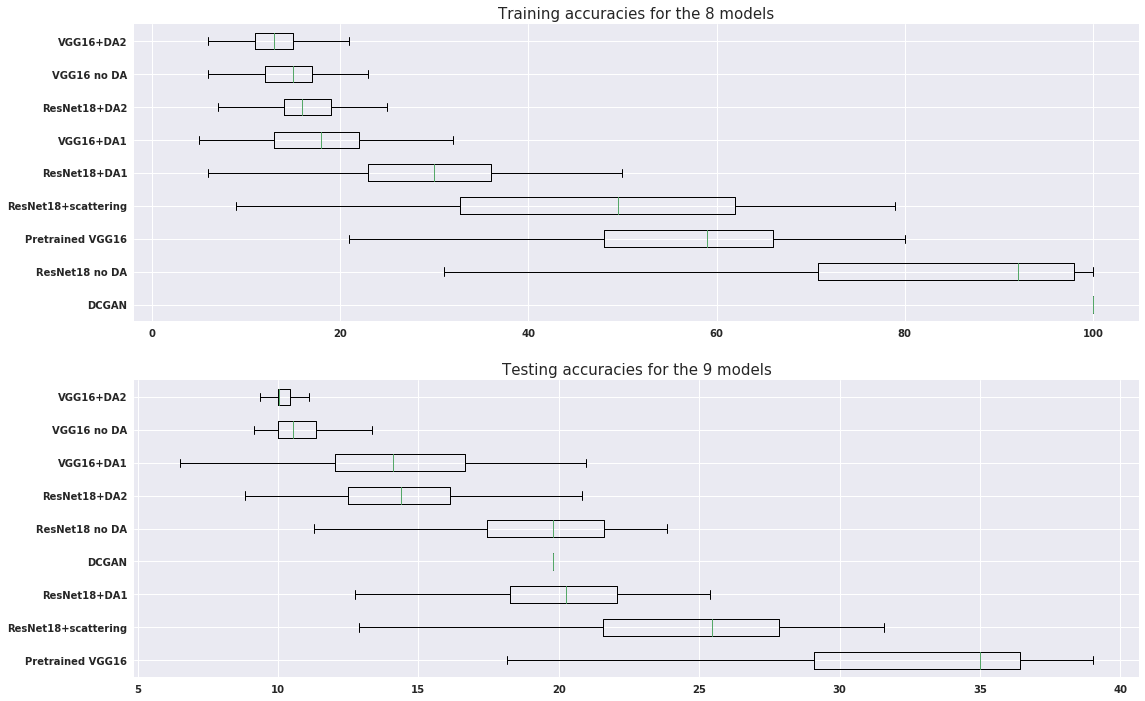

In [21]:
# Load results from multiple trainings 
train_loss_r18sc, test_loss_r18sc, train_acc_r18sc, test_acc_r18sc = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18_scattered.pk', 'rb'))
train_loss_r18da, test_loss_r18da, train_acc_r18da, test_acc_r18da = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18da.pk', 'rb'))
train_loss_r18noda, test_loss_r18noda, train_acc_r18noda, test_acc_r18noda = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18noda.pk', 'rb'))
train_loss_vgg16da, test_loss_vgg16da, train_acc_vgg16da, test_acc_vgg16da = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16da.pk', 'rb'))
train_loss_vgg16noda, test_loss_vgg16noda, train_acc_vgg16noda, test_acc_vgg16noda = pickle.load(open(path+'/Simulations/DLIP-TP3/N10LRr0_train_test_vgg16noda.pk', 'rb'))
train_loss_vgg16p, test_loss_vgg16p, train_acc_vgg16p, test_acc_vgg16p = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16pretrained.pk', 'rb'))
train_loss_r18, test_loss_r18, train_acc_r18, test_acc_r18 = pickle.load(open(path+'/Simulations/N10LRr0_train_test_resnet18.pk', 'rb'))
train_loss_vgg16, test_loss_vgg16, train_acc_vgg16, test_acc_vgg16 = pickle.load(open(path+'/Simulations/N10LRr0_train_test_vgg16.pk', 'rb'))

# Define a small function to return mean and std
def stat(train_acc, test_acc):
  imax = np.argmax(test_acc, axis=1)
  train_acc_, test_acc_ = train_acc[np.arange(10), imax], test_acc[np.arange(10), imax]
  return np.mean(train_acc_), np.std(train_acc_), np.mean(test_acc_), np.std(test_acc_)

# Compute means, std
m_tr_v16da, std_tr_v16da, m_te_v16da, std_te_v16da = stat(train_acc_vgg16da, test_acc_vgg16da)
m_tr_v16noda, std_tr_v16noda, m_te_v16noda, std_te_v16noda = stat(train_acc_vgg16noda, test_acc_vgg16noda)
m_tr_r18da, std_tr_r18da, m_te_r18da, std_te_r18da = stat(train_acc_r18da, test_acc_r18da)
m_tr_r18noda, std_tr_r18noda, m_te_r18noda, std_te_r18noda = stat(train_acc_r18noda, test_acc_r18noda)
m_tr_r18sc, std_tr_r18sc, m_te_r18sc, std_te_r18sc = stat(train_acc_r18sc, test_acc_r18sc)
m_tr_v16p, std_tr_v16p, m_te_v16p, std_te_v16p = stat(train_acc_vgg16p, test_acc_vgg16p)
m_tr_r18, std_tr_r18, m_te_r18, std_te_r18 = stat(train_acc_r18, test_acc_r18)
m_tr_v16, std_tr_v16, m_te_v16, std_te_v16 = stat(train_acc_vgg16, test_acc_vgg16)
m_tr_dcgan, std_tr_dcgan, m_te_dcgan, std_te_dcgan = 100, 0, 19.78, 0


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)
plt.figure(figsize=(18, 12))
plt.subplot(2,1,1)
plt.boxplot([[100], train_acc_r18noda.flatten(),  train_acc_vgg16p.flatten(),
             train_acc_r18sc.flatten(), train_acc_r18.flatten(),
             train_acc_vgg16.flatten(), train_acc_r18da.flatten(),
             train_acc_vgg16noda.flatten(), train_acc_vgg16da.flatten()], vert=False)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['DCGAN', 'ResNet18 no DA', 'Pretrained VGG16',
                                      'ResNet18+scattering', 'ResNet18+DA1',
                                      'VGG16+DA1', 'ResNet18+DA2',
                                      'VGG16 no DA', 'VGG16+DA2'])
plt.title('Training accuracies for the 8 models', fontsize=15)
plt.subplot(2,1,2)
plt.boxplot([test_acc_vgg16p.flatten(), test_acc_r18sc.flatten(),
             test_acc_r18.flatten(), [19.78], test_acc_r18noda.flatten(),
             test_acc_r18da.flatten(), test_acc_vgg16.flatten(),
             test_acc_vgg16noda.flatten(), test_acc_vgg16da.flatten()], vert=False)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['Pretrained VGG16', 'ResNet18+scattering',
                                         'ResNet18+DA1', 'DCGAN', 'ResNet18 no DA',
                                       'ResNet18+DA2', 'VGG16+DA1',
                                         'VGG16 no DA', 'VGG16+DA2'])
plt.title('Testing accuracies for the 9 models', fontsize=15)
plt.show()

> | Model | Number of  epochs  | Train accuracy | Test accuracy | Test accuracy (full data)
|------|------|------|------|------|
|   ResNet18 no DA  | 20 | 97.30 ± 2.238%  |23.165 ± 0.524% |?|
|   VGG16 no DA | 20 | 14.900 ± 4.277% |  12.528 ± 0.990%|?|
|   ResNet18  DA1 | 20 | 35.500 ± 3.828% | 24.672 ± 0.777% |93.02% (a)|
|   VGG16  DA1 | 20 | 21.300 ± 3.466% | 18.465 ± 1.940% |92.64% (a)|
|   ResNet18  DA2 | 20 | 18.100 ± 3.390% |  18.837 ± 1.187%|?|
|   VGG16  DA2 | 20 | 12.900 ± 4.867% |12.239 ± 1.193%|?|
| DCGAN | 200 (no training) |100.000 ± 0.000% | 19.780 ± 0.000% |82.80% (b)|
|   **Pretrained VGG16**  | 40 | 69.400 ± 5.219% | **37.909 ± 0.603%** |92.64% (a) |
| Scattering ResNet18 | 30 | 68.200 ± 6.046% | 29.976 ± 1.107%| 93.10% (b)|

>Sources:
>- (a): Kuang Liu's github:  https://github.com/kuangliu/pytorch-cifar
>- (b): "Scaling the Scattering Transform: Deep Hybrid Networks", Oyallon et al. (2017), https://arxiv.org/pdf/1703.08961.pdf

> To conclude, I choose to follow the chronology of the assignment. The first architectures implemented here as part of a classical supervised classification, were ResNet 18 and VGG 16. Those architectures were trained from scratch with 20 epochs. The figure above shows the distribution of the accuracies obtained for each of those 20 epochs, repeated 10 times (10 independent simulations). The table indicates, on the basis of those 10 simulations, the mean and standard deviations of the best accuracy obtained (during say, 20 epochs) on the test set, and the corresponding accuracy on train set. I will first focus on the accuracies obtained on the test set composed of 10 000 images. To come back to ResNet 18 and VGG16, one first trained the models using some techniques of data augmentation, which I called "+DA1". The latter correspond to horizontal flipping and random cropping. ResNet18 gave better results than VGG16, with less parameters to train. Both networks behave well in terms of overfitting. In fact, questions 3 and 4 were, I think, dedicated to trying no data augmentation at all for both ResNet and VGG architectures, which I tried later on, question 8. This approach reveals that, still, ResNet18 performs well on test set with an average accuracy of 23.165% (24.672% with DA1). We can't say the same thing for VGG16, which dramatically falls to 12.528%. For ResNet18, no data augmentation implies a huge overfit (97.30% on train set), which is not found for the 2 other data augmentation strategies, DA1 and DA2. Interestingly, VGG16 do not suffer from such overfit in any of the data augmentation strategy, which would be valuable if it didn't give such poor results. As mentioned just above, the goal of this assignment was also to try some more complex data augmentation strategy beyond translation. It's interesting to see how DA2 (where transformations are various) significantly reduces the overfit observed with the first DA strategy (10.828 to -0.737 pts of accuracy). Nevertheless, DA2 also diminishes the accuracies on test set for both architectures ! This is linked to question 7 on the drawback of data augmentation with small data: it can significantly impacts the data set in terms of outliers and the outcome of some transformations can lead to non-sensical images that, with small data, corrupt the modelling. In fact, it would be more valuable to train the parameters controlling the geometric transformations instead, as evoked question 7. This is clear here: combining cropping, flipping, shearing and/or some others "unsupervised"/naive transformations becomes too risky and has a huge impact on the performance. 
>
> Using VGG16 network through transfer learning led to the best accuracy on test set. This approach can be costly if some fully connected layers have parameters to be learned but remains very easy to implement. Here, ImageNet features are relevant for our classification task. However, some cases where we deal with specific data sets can't be handled with transfer learning. For example, it's really hard to do transfer learning in medical imaging which suffers from very small amount of data! 
>
> Despite it's wonderful potential, DCGAN was quite deceptive. In fact, when talking with other MVA students, I heard that some of them reached 30% of accuracy with DCGAN, so I will qualify my analysis. In fact, using DCGAN weights is a kind of transfer learning too, from which comes the same advantages and drawbacks. Moreover, I used here weights obtained with a 200 epochs training on CIFAR-10; which has no sense for a real-life application. As advised, I should have used DCGAN trained on ImageNet but I was faced up to many difficulties to achieve it. In any case, DCGAN (when loading pretrained weights) is particularly fast, as training only consists in tuning a SVM. It is particularly robust to overfitting when constant $C$ is well tuned. Here I used the smallest $C$ that gave the best accuracy on test set, and in fact led to a perfect training accuracy... Recall that here $n << p$ which explains such overfitting (the system is over-determined). DCGAN is a very elegant unsupervised learning technique which certainly leads to better results than that of my implementation. I tried lasso logistic regression but it was really not satisfying. 
>
> To finish with, ResNet18 with scattering technique led to amazing results compared to DA1 (for ResNet). Indeed, test accuracy jumped from 24.672% to 29.976% only using a single transformation: scattering. Oyallon et al. obtained 38.9 ± 1.2% with a Wide Residual Network + Scattering on the same test set while training on 100 samples. The also achieve state-of-the-art performance on the whole data set. This inventive transformation is more prone to overfitting as I didn't add some others  transformations. 
>
> To conclude, I would also like to underline that I didn't implement any weakly-supervised technique, which is a pity in view of the course. I guess I will have more time later on to focus on it, as it has an incredible potential for small data, context that I will have to deal with during my internship this summer (medical imaging). 